In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
import operator
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import os
import settings

import Stemmer
import statsmodels.api as sm

In [176]:
def read_data():
    df = pd.read_excel(os.path.join(settings.PROCESSED_DIR, "all_with_liwc_segmented.xls"), encoding="ISO-8859-1")
    return df

In [177]:
df = read_data()

In [178]:
df['norm_persuasive'].describe()

count    2406.000000
mean      137.190942
std       167.388307
min         0.000000
25%        37.566308
50%        90.985507
75%       180.264298
max      2758.625723
Name: norm_persuasive, dtype: float64

In [179]:
persuasive_median = df['norm_persuasive'].median()
persuasive_upper_quantile = df['norm_persuasive'].quantile(.75)

In [180]:
df['persuasive_label'] = np.where(df['persuasive'] >= persuasive_median, 1, 0)

In [181]:
from sklearn.feature_extraction.text import CountVectorizer
stemmer = SnowballStemmer('english')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [182]:
count_vect = StemmedCountVectorizer(analyzer="word", stop_words='english', min_df=2)
X_train_counts = count_vect.fit_transform(df['transcript'])
X_train_counts.shape

(2406, 20462)

In [183]:
sorted(count_vect.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)

[('î¾', 20461),
 ('éte', 20460),
 ('èé', 20459),
 ('èâthank', 20458),
 ('èâso', 20457),
 ('èâ', 20456),
 ('ève', 20455),
 ('èt', 20454),
 ('ès', 20453),
 ('ère', 20452),
 ('èm', 20451),
 ('èll', 20450),
 ('èd', 20449),
 ('ås', 20448),
 ('åres', 20447),
 ('åre', 20446),
 ('åme', 20445),
 ('àvet', 20444),
 ('àveli', 20443),
 ('àve', 20442),
 ('zx81', 20441),
 ('zurich', 20440),
 ('zulu', 20439),
 ('zuckerman', 20438),
 ('zuckerberg', 20437),
 ('zuccotti', 20436),
 ('zopa', 20435),
 ('zooplankton', 20434),
 ('zoop', 20433),
 ('zoonot', 20432),
 ('zoom', 20431),
 ('zoolog', 20430),
 ('zoo', 20429),
 ('zone', 20428),
 ('zombi', 20427),
 ('zoe', 20426),
 ('zodiac', 20425),
 ('zipper', 20424),
 ('ziploc', 20423),
 ('ziplin', 20422),
 ('zipcar', 20421),
 ('zip', 20420),
 ('zine', 20419),
 ('zinc', 20418),
 ('zimbardo', 20417),
 ('zimbabwean', 20416),
 ('zimbabw', 20415),
 ('zillion', 20414),
 ('zilch', 20413),
 ('zika', 20412),
 ('zigzag', 20411),
 ('zig', 20410),
 ('zheng', 20409),
 ('zf', 20

In [184]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(2406, 20462)

In [185]:
from sklearn.model_selection import train_test_split

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, df['persuasive_label'])

In [187]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)

In [188]:
predicted = clf.predict(X_test)
np.mean(predicted == y_test)

0.63787375415282388

In [189]:
clf.score(X_test, y_test)

0.63787375415282388

Classification accuracy is 69%

Null accuracy: accuracy that could be achieved by always predicting the most frequent class


In [190]:
# calculate null accuracy in a single line of code
# only for binary classification problems coded as 0/1
max(y_test.mean(), 1 - y_test.mean())

0.5382059800664452

This means that a dumb model that always predicts 0 would be right 56% of the time

This shows how classification accuracy is fairly good as 13% higher than a dumb model
It's a good way to know the minimum we should achieve with our models

In [196]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

In [199]:
standard_confusion_matrix(y_test, predicted)

array([[310, 204],
       [ 14,  74]])

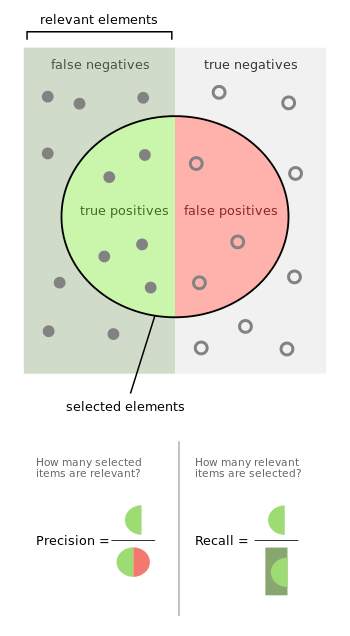

In [191]:
recall = recall_score(y_test, predicted)
recall

0.95679012345679015

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

In [192]:
precision = precision_score(y_test, predicted)
precision

0.60311284046692604

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

In [193]:
F1 = 2 * (precision * recall) / (precision + recall)
F1

0.73985680190930792

The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.

In [230]:
def show_most_informative_features(vectorizer, clf, n=100):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    top_words = []
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        top_words.append((coef_2, fn_2))
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
    top_words_df = pd.DataFrame(top_words, columns=['coefficient', 'word'])
    top_words_df.to_csv('top-words-persuasive.csv')
    return top_words_df

In [231]:
top_words_df = show_most_informative_features(count_vect,clf)

	-10.4201	040            		-6.4163	peopl          
	-10.4201	109            		-6.6375	like           
	-10.4201	113            		-6.7700	think          
	-10.4201	125th          		-6.8119	thing          
	-10.4201	143            		-6.8391	just           
	-10.4201	153            		-6.8972	year           
	-10.4201	165            		-6.9012	go             
	-10.4201	167            		-6.9101	know           
	-10.4201	168            		-6.9978	time           
	-10.4201	1771           		-7.0029	world          
	-10.4201	1772           		-7.0222	want           
	-10.4201	1860s          		-7.0501	ve             
	-10.4201	1866           		-7.0620	make           
	-10.4201	1868           		-7.0806	look           
	-10.4201	1874           		-7.0969	don            
	-10.4201	1876           		-7.0993	say            
	-10.4201	1883           		-7.1029	realli         
	-10.4201	1887           		-7.1245	work           
	-10.4201	1889           		-7.1490	way            
	-10.4201	1890           		-7.1

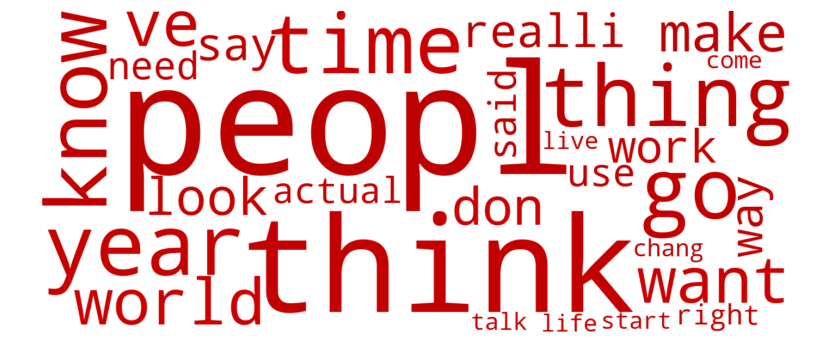

In [238]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
# Read the whole text.
text = top_words_df['word'].iloc[0:30].str.cat(sep=', ')

# Generate a word cloud image

wordcloud = WordCloud(width=1400, height=600, background_color='white').generate(text)

#change the value in return to set the single color need, in hsl format.
def red_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%%, %d%%)" % np.random.randint(37,41))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(14,6))
wordcloud.recolor(color_func = red_color_func)
plt.imshow(wordcloud, interpolation='bilinear')
#change the color setting
plt.axis("off")
plt.savefig('Most Informative Features - Persuasive')
plt.show()
